In [4]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [8]:
len(words)

32033

In [10]:
# build the vocabulary of charcters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)
print(stoi)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}


In [181]:
# build the dataset

block_size = 3
X, Y = [], []
for w in words:
    #print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        #print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix] # crop and append
        
X = torch.tensor(X)
Y = torch.tensor(Y)

In [15]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [277]:
# build the dataset

def build_dataset(words):
    block_size = 3
    X, Y = [], []
    for w in words:
        #print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix] # crop and append
            
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182437, 3]) torch.Size([182437])
torch.Size([22781, 3]) torch.Size([22781])
torch.Size([22928, 3]) torch.Size([22928])


In [24]:
C = torch.randn((27, 2))

In [38]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [61]:
W1 = torch.randn(6, 100)
b1 = torch.randn(100)

In [65]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # lots of magic happening here with the -1 and the view. Explained in video
# also the broadcasting of + b1

In [63]:
h

tensor([[-0.9593, -0.3776, -0.7493,  ..., -0.9858, -0.9426, -0.8933],
        [-0.7169,  0.1580,  0.6880,  ..., -0.6611, -0.5161, -0.7188],
        [ 0.5951,  0.9523,  0.6151,  ...,  0.5833,  0.9983,  0.5611],
        ...,
        [ 0.6004, -0.2954,  0.7402,  ..., -0.4350,  0.5146,  0.7161],
        [ 0.6658, -0.8533, -0.7149,  ..., -0.9926,  0.9914,  0.7138],
        [-0.4042, -0.9987, -0.9466,  ..., -1.0000, -0.9746,  0.4030]])

In [64]:
h.shape

torch.Size([32, 100])

In [67]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [68]:
logits = h @ W2 + b2

In [69]:
logits.shape

torch.Size([32, 27])

In [70]:
counts = logits.exp()

In [73]:
prob = counts / counts.sum(1, keepdims=True)

In [74]:
prob.shape

torch.Size([32, 27])

In [78]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(14.2965)

In [79]:
# Cleanup

In [80]:
X.shape, Y.shape

(torch.Size([32, 3]), torch.Size([32]))

In [278]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2))
W1 = torch.randn(6, 300)
b1 = torch.randn(300)
W2 = torch.randn((300, 27))
b2 = torch.randn(27)
parameters = [C, W1, b1, W2, b2]

In [280]:
sum(p.nelement() for p in parameters)

10281

In [281]:
for p in parameters:
    p.requires_grad = True

In [267]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [288]:
lri = []
lossi = []
stepi = []

for i in range(30000):
    
    # minibatch
    ix = torch.randint(0, X.shape[0], (32,))
    
    # forward pass
    emb = C[X][ix] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    #counts = logits.exp()
    #prob = counts / counts.sum(1, keepdims=True)
    #loss = -prob[torch.arange(32), Y].log().mean()
    loss = F.cross_entropy(logits, Y[ix])

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = lrs[i]
    for p in parameters:
        p.data += -0.1 * p.grad
        
    # track stats
    lri.append(lr)
    lossi.append(loss.item())
    stepi.append(i)

print(loss.item())

IndexError: index 1000 is out of bounds for dimension 0 with size 1000

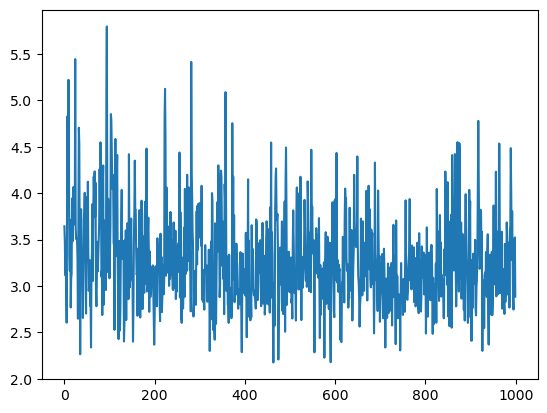

In [286]:
plt.plot(stepi, lossi)

In [287]:
emb = C[X] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Y)
loss

tensor(3.0626, grad_fn=<NllLossBackward0>)

In [188]:
logits.max(1)

torch.return_types.max(
values=tensor([ 4.8240,  7.3526, 11.9427,  ...,  8.7976,  8.4255,  8.6498],
       grad_fn=<MaxBackward0>),
indices=tensor([ 1,  9,  9,  ..., 19, 12, 15]))

In [ ]:
# training, dev/validation, test
# 80, 10, 10

# training - parameters
# dev - hyperparams
# test - evaluate performance